In [74]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [75]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'

Running on localhost


## Custom model analysis

In [76]:
img_width, img_height, batch_size = 180, 180, 64

In [77]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [78]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle=False)

val_data_shuffled = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [79]:
class_dict  = train_data.class_indices
class_names = []
for cat in class_dict.keys():
    class_names.append(cat)
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [80]:
custom_model = keras.models.load_model('saved_models/custom_model_V2')

### prediction examples

In [81]:
def plot_prediction(img, model, label=None, rescale_input=False):
    plt.imshow(img)
    plt.show()
    img = np.expand_dims(img, axis=0)
    
    if rescale_input:
       img = img / 255.

    pred_vect = model.predict(img)

    pred_idx_sorted  = np.argsort(pred_vect).flatten()
    proba_sorted     = np.sort(pred_vect).flatten()

    if label is not None:
        print("True label : ",class_names[label.argmax()])

    for i in range(1, 5):
        print(" --> ", class_names[pred_idx_sorted[-i]]," predicted with proba " ,round(proba_sorted[-i] * 100, 3), "%")
        
    print("---------------------------------------------")

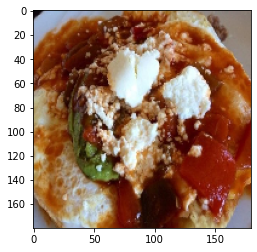

True label :  huevos_rancheros
 -->  huevos_rancheros  predicted with proba  39.662 %
 -->  waffles  predicted with proba  14.981 %
 -->  creme_brulee  predicted with proba  7.367 %
 -->  pancakes  predicted with proba  6.582 %
---------------------------------------------


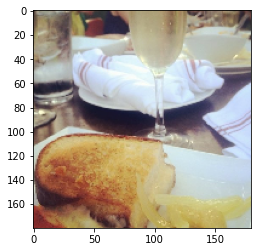

True label :  grilled_cheese_sandwich
 -->  donuts  predicted with proba  18.117 %
 -->  cheese_plate  predicted with proba  8.2 %
 -->  cheesecake  predicted with proba  6.459 %
 -->  churros  predicted with proba  4.974 %
---------------------------------------------


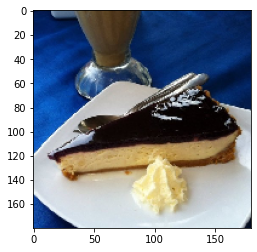

True label :  cheesecake
 -->  chocolate_cake  predicted with proba  19.437 %
 -->  mussels  predicted with proba  7.065 %
 -->  cheese_plate  predicted with proba  6.262 %
 -->  churros  predicted with proba  5.536 %
---------------------------------------------


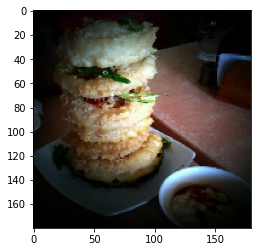

True label :  onion_rings
 -->  apple_pie  predicted with proba  8.435 %
 -->  ice_cream  predicted with proba  7.612 %
 -->  bread_pudding  predicted with proba  6.468 %
 -->  grilled_cheese_sandwich  predicted with proba  6.15 %
---------------------------------------------


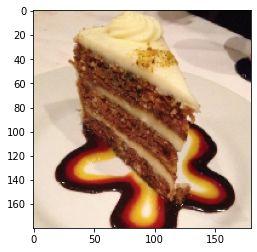

True label :  carrot_cake
 -->  grilled_cheese_sandwich  predicted with proba  21.168 %
 -->  carrot_cake  predicted with proba  15.544 %
 -->  gyoza  predicted with proba  11.504 %
 -->  peking_duck  predicted with proba  9.842 %
---------------------------------------------


In [82]:
for _ in range(5):
    random_batch = random.randint(0,31)
    random_img = random.randint(0,31)

    img_test = val_data_shuffled[random_batch][0][random_img]
    label    = val_data_shuffled[random_batch][1][random_img]
    plot_prediction(img_test, custom_model, label=label)

### missclassified examples

In [83]:
def find_missclassified(model, max_missclassified=9):
    missclassified = []
    max_batch = len(val_data_shuffled)
    for batch in range(max_batch):
        for img_id in range(batch_size):
            img   = np.expand_dims(val_data_shuffled[batch][0][img_id], axis=0)
            true_label = class_names[val_data_shuffled[batch][1][img_id].argmax()]
            pred_vect = model.predict(img).flatten()
            
            pred_label = class_names[pred_vect.argmax()]
            proba = round(pred_vect.max() * 100, 3) 
            if true_label != pred_label:
                missclassified.append({'true_label' : true_label, 
                                       'pred_label' : pred_label, 
                                       'proba'      : proba, 
                                       'img'        : img[0]
                                    })

            if len(missclassified) >= max_missclassified:
                return missclassified

    return missclassified

def plot_missclassified(missclassified):
    if len(missclassified) != 9:
        print("Bad length for missclassified, should be 9")
        print("actual length : ", len(missclassified))
    else:
        plt.figure(figsize=(10, 10))
        for i in range(len(missclassified)):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(missclassified[i]['img'])
            title = 'True : ' + missclassified[i]['true_label'] + \
                    '\n Predicted : ' + missclassified[i]['pred_label']
            plt.title(title)
            plt.axis("off")
        
        plt.show()

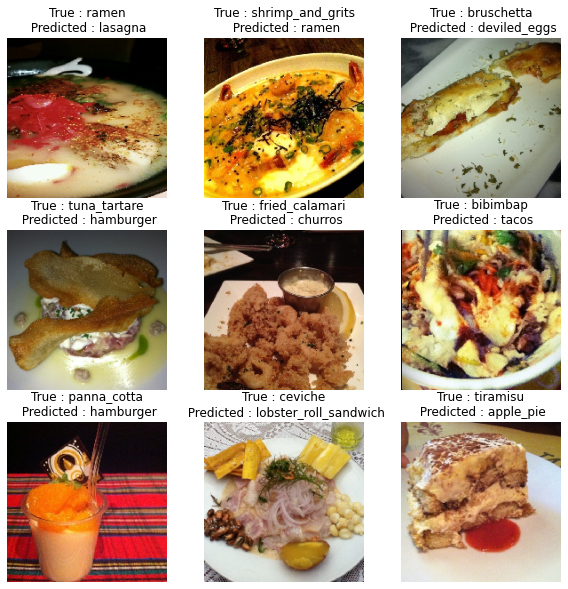

In [84]:
missclassified = find_missclassified(custom_model)
plot_missclassified(missclassified)

### confusion matrix

In [85]:
Y_pred = custom_model.predict(val_data, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

316/316 [==============================] - 179s 564ms/step


In [86]:
print("Accuracy (%): ", round((y_pred == val_data.classes).mean()*100,3))

Accuracy (%):  32.139


<Figure size 1800x1800 with 0 Axes>

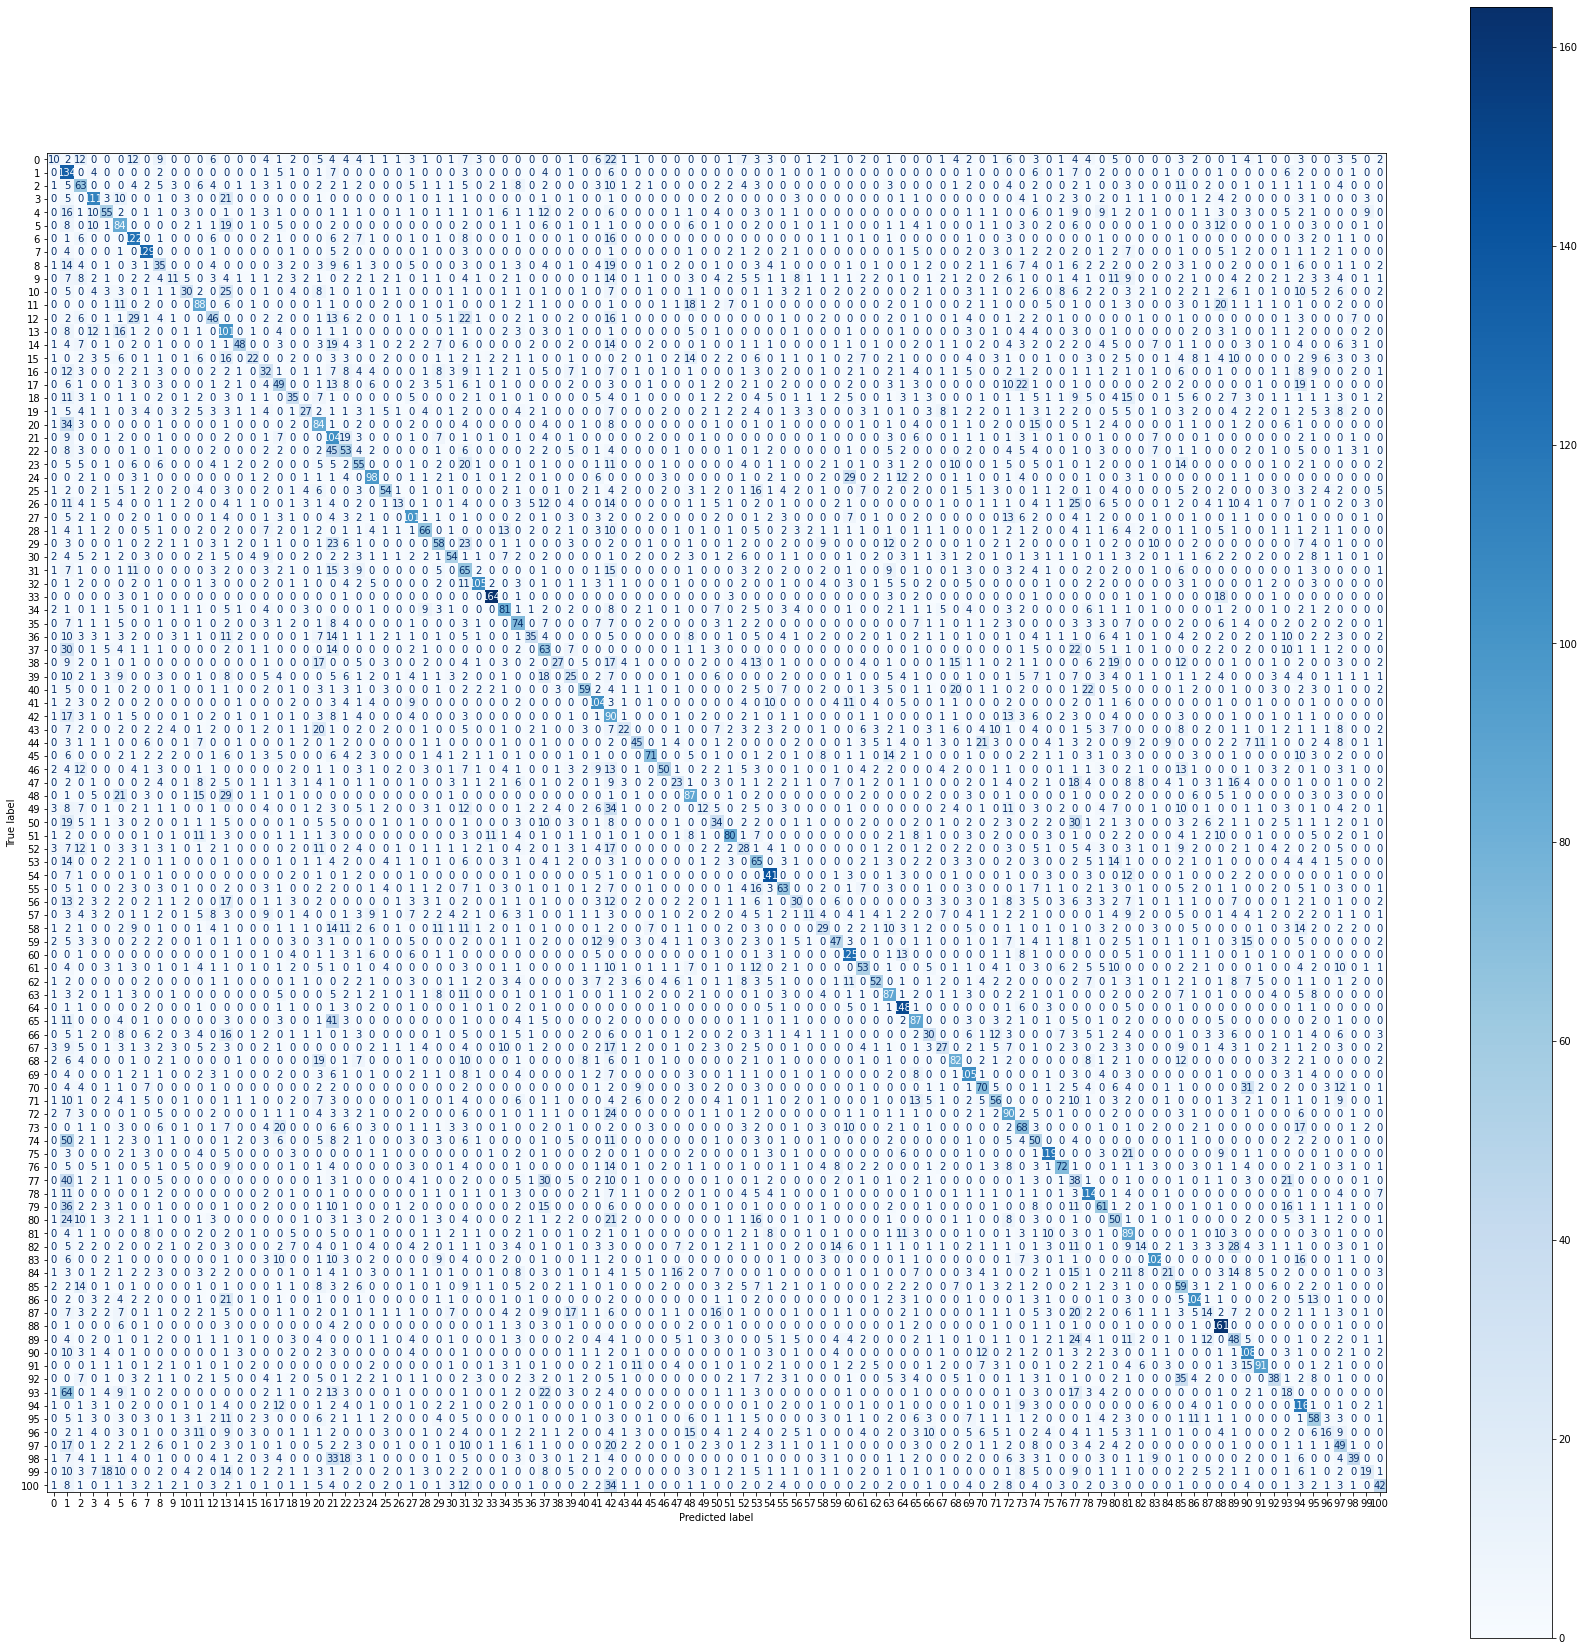

In [87]:
y_test = val_data.classes
labels = class_names

plt.figure(figsize=(25,25))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm) #, display_labels=labels)

fig, ax = plt.subplots(figsize=(30, 30))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [88]:
custom_model_classification_report = classification_report(y_test, y_pred, target_names=class_names)

In [109]:
# print(custom_model_classification_report)

## Inception V3

In [89]:
batch_size = 32

img_height = 224
img_width = 224

In [90]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [91]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle=False)

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle=False)

val_data_shuffled = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    shuffle=True)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [92]:
inveptionV3 = keras.models.load_model('saved_models/inceptionV3_15epochs')

### prediction examples

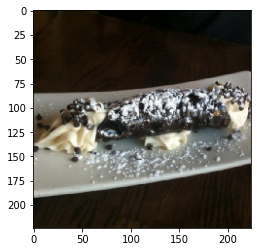

True label :  cannoli
 -->  cannoli  predicted with proba  100.0 %
 -->  cheese_plate  predicted with proba  0.0 %
 -->  chocolate_mousse  predicted with proba  0.0 %
 -->  french_toast  predicted with proba  0.0 %
---------------------------------------------


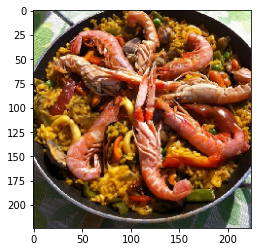

True label :  paella
 -->  paella  predicted with proba  99.887 %
 -->  peking_duck  predicted with proba  0.048 %
 -->  bibimbap  predicted with proba  0.012 %
 -->  sashimi  predicted with proba  0.007 %
---------------------------------------------


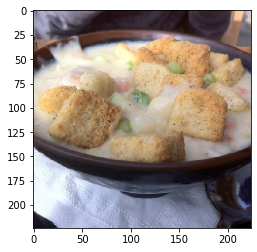

True label :  clam_chowder
 -->  clam_chowder  predicted with proba  34.529 %
 -->  omelette  predicted with proba  20.391 %
 -->  ramen  predicted with proba  11.257 %
 -->  macaroni_and_cheese  predicted with proba  5.958 %
---------------------------------------------


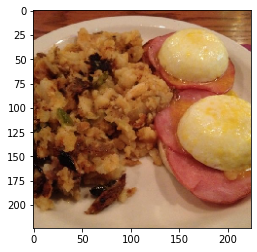

True label :  eggs_benedict
 -->  eggs_benedict  predicted with proba  99.914 %
 -->  beef_tartare  predicted with proba  0.029 %
 -->  croque_madame  predicted with proba  0.026 %
 -->  hamburger  predicted with proba  0.014 %
---------------------------------------------


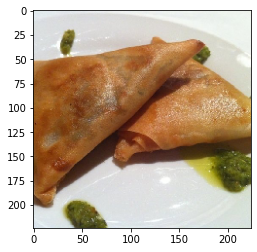

True label :  samosa
 -->  samosa  predicted with proba  99.909 %
 -->  spring_rolls  predicted with proba  0.076 %
 -->  peking_duck  predicted with proba  0.005 %
 -->  gyoza  predicted with proba  0.004 %
---------------------------------------------


In [93]:
for _ in range(5):
    random_batch = random.randint(0,31)
    random_img = random.randint(0,31)

    img_test = val_data_shuffled[random_batch][0][random_img]
    label    = val_data_shuffled[random_batch][1][random_img]
    plot_prediction(img_test, inveptionV3, label=label)

### missclassified examples

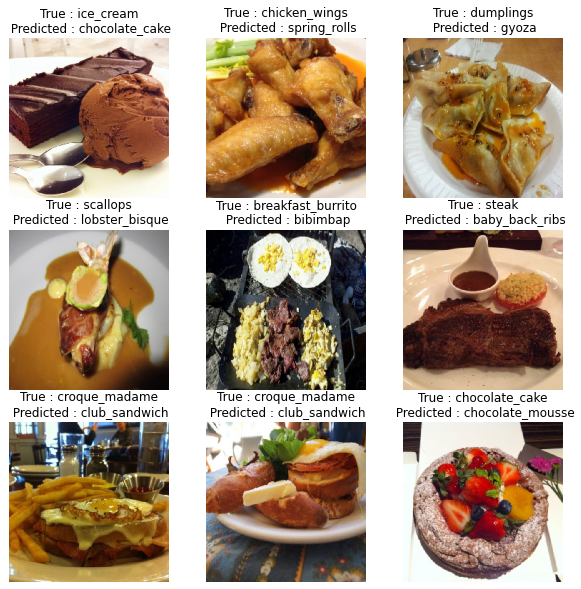

In [94]:
missclassified = find_missclassified(inveptionV3)
plot_missclassified(missclassified)

### confusion matrix

In [95]:
Y_pred = inveptionV3.predict(val_data, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

632/632 [==============================] - 1583s 3s/step


In [96]:
print("Accuracy (%): ", round((y_pred == val_data.classes).mean()*100,3))

Accuracy (%):  75.436


<Figure size 1800x1800 with 0 Axes>

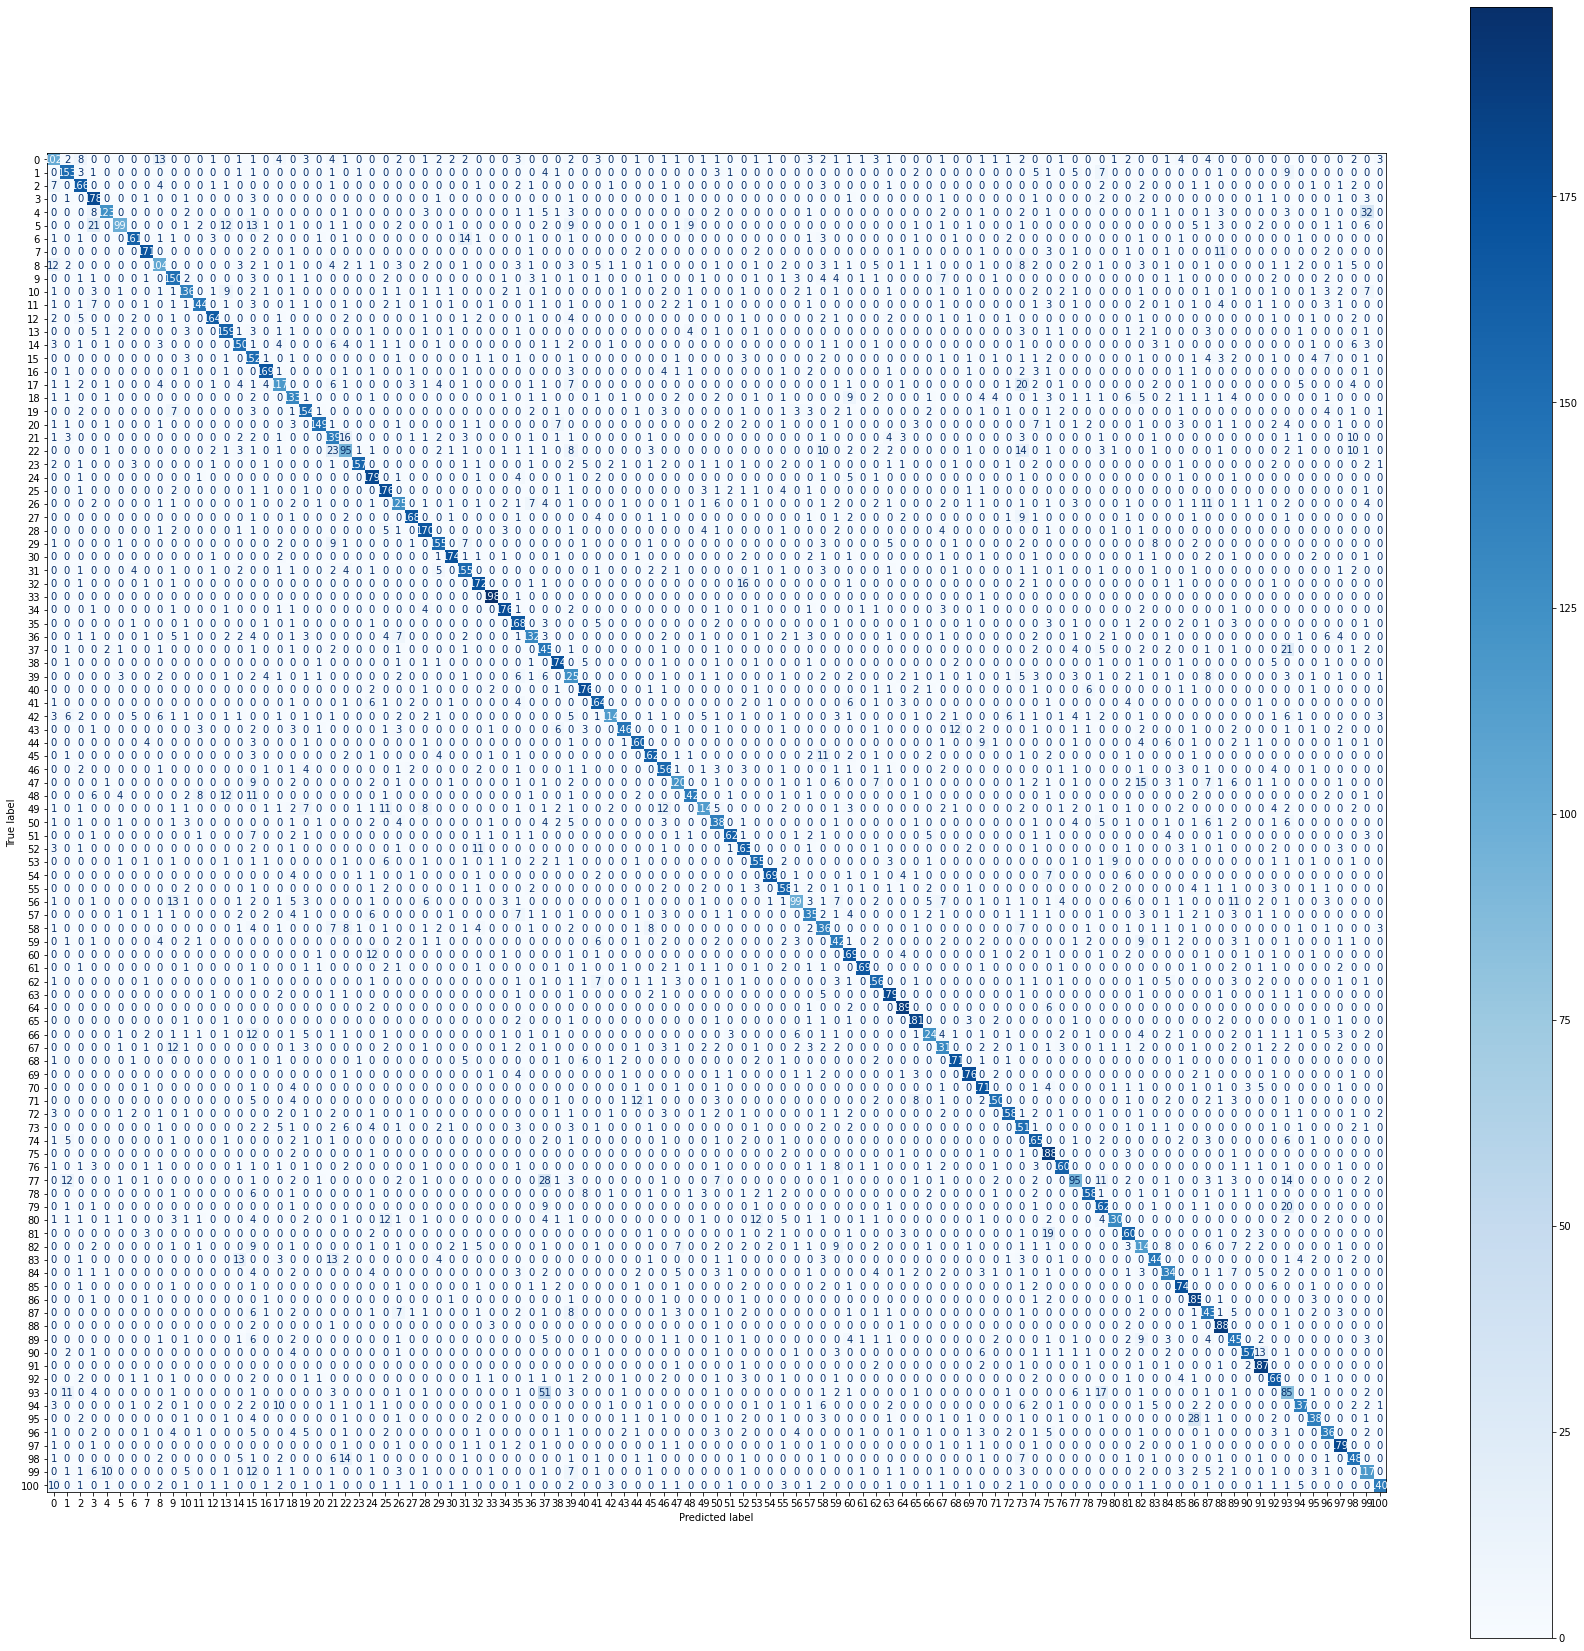

In [97]:
y_test = val_data.classes
labels = class_names

plt.figure(figsize=(25,25))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm) #, display_labels=labels)

fig, ax = plt.subplots(figsize=(30, 30))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [98]:
inceptionV3_classification_report = classification_report(y_test, y_pred, target_names=class_names)

In [107]:
#print(inceptionV3_classification_report)